# Сегментирование покупателей интернет-магазина товаров для дома и быта «Пока все ещё тут»

**Задача:**

Сегментировать покупателей по профилю потребления

- Проведите исследовательский анализ данных
- Сегментируйте покупателей на основе истории их покупок
- Сформулируйте и проверьте статистические гипотезы

Датасет описывает транзакции интернет-магазина товаров для дома и быта «Пока все ещё тут».

Колонки в  *ecommerce_dataset.csv* :

- `date` — дата заказа;
- `customer_id` — идентификатор покупателя;
- `order_id` — идентификатор заказа;
- `product` — наименование товара;
- `quantity` — количество товара в заказе;
- `price` — цена товара.

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
import datetime as dt
from datetime import datetime
import plotly.express as px

import warnings
warnings.filterwarnings("ignore")

# зададим параметры для графиков
plt.rcParams.update({'figure.figsize': (10,5)})
sns.set()

from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import *
from sklearn.cluster import KMeans

from sklearn import preprocessing

from statsmodels.stats.proportion import proportions_ztest

### Предобрабодка данных

In [38]:
# Загрузим наши данные в переменную
try:
    data = pd.read_csv('/datasets/ecommerce_dataset.csv')
except:
    data = pd.read_csv('ecommerce_dataset.csv')

# Сохраним датасет до обработкиэ
data_original = data.copy()
data_original_shape = data.shape

print(display(data.head(5)))
# Изучим данные
data.info()

,date,customer_id,order_id,product,quantity,price
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0
3,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0
4,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0


None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6737 entries, 0 to 6736
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         6737 non-null   int64  
 1   customer_id  6737 non-null   object 
 2   order_id     6737 non-null   int64  
 3   product      6737 non-null   object 
 4   quantity     6737 non-null   int64  
 5   price        6737 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 315.9+ KB


В датасете нет пустых значений, названия колонок соответвуют нормам, только колонка date требует изменения типа и формата записи данных.

In [39]:
# Поменяем формат даты
data['date'] = pd.to_datetime(data['date'].astype('str'), format='%Y%m%d%H')

# Создадим дополнительные колонки 
data['year'] = data['date'].dt.year #год
data['month'] = data['date'].dt.month #номер месяца
data['week'] = data['date'].dt.isocalendar().week #номер недели
data['week_day'] = data['date'].dt.dayofweek #день недели, где 0 - понедельник, 6 - воскресенье
data['day'] =  pd.to_datetime(data['date']).dt.to_period('d') #день
data['hour'] = data['date'].dt.hour #час
data['month_year'] = pd.to_datetime(data['date']).dt.to_period('M') #год+месяц

data.head(2)

,date,customer_id,order_id,product,quantity,price,year,month,week,week_day,day,hour,month_year
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,2018,10,40,0,2018-10-01,0,2018-10
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0,2018,10,40,0,2018-10-01,0,2018-10


In [40]:
# Проверим на наличие явных дубликатов
duplicates_unique = data[data.duplicated(keep='first')].shape
print('Кол-во задублированных строк:', duplicates_unique[0])

# Проверим на наличие неполных дубликатов
duplicates_unique_2 = data[data.duplicated(subset=['customer_id','order_id','product','quantity','price'], keep='last')].shape
print('Кол-во задублированных транзакций с разным временем:', duplicates_unique_2[0])

Кол-во задублированных строк: 0
Кол-во задублированных транзакций с разным временем: 1864


При проверке транзакций найденных дубликатов, увидим что в одном заказе есть несколько транзакций одного товара в разное время. Будем считать, что последняя транзакция будет считаться успешной оплатой и приходом средств из банка. Поэтому удалим все промежуточные транзакции, количество заказов и покупателей при этом не изменится.

In [41]:
#проверим, нет ли одинаковых номеров заказов у разных пользователей
check_customer_id = data.groupby('order_id')['customer_id'].nunique().sort_values(ascending = False).reset_index()
check_customer_id[check_customer_id['customer_id']>=2]
#data[data['order_id']==72845]

,order_id,customer_id
0,72845,4
1,71480,3
2,69485,3
3,69310,2
4,69833,2
5,72790,2
6,72778,2
7,14872,2
8,71542,2
9,71054,2


3 заказа имеют несколько покупателей. Заказы в рамках клиента одинаковые и отличаются только датой или временем совершения заказа. Такие заказы будем считать как один и оставим клиента, который последний по дате и времени выполнил заказ

In [42]:
#уберем промежуточные транзакции и лишние заказы дубли с разными клиентами
data = data.drop_duplicates(subset=['order_id','product','quantity'], keep='last').reset_index(drop=True)
data[data['order_id']==69485] = data[data['order_id']==69485].drop_duplicates(subset=['order_id'], keep='last').reset_index(drop=True)

print(data.shape)
print('Процент удаленных строк:', round(duplicates_unique_2[0]/data_original_shape[0]*100),'%')

(4837, 13)
Процент удаленных строк: 28 %


In [43]:
#проверка
check_customer_id = data.groupby('order_id')['customer_id'].nunique().sort_values(ascending = False).reset_index()
check_customer_id[check_customer_id['customer_id']>=2]

,order_id,customer_id


Сгуппируем транзации по заказам и создадим датасет с итоговой суммой заказов. Предварительно посчитаем сумму стоимости товара, где несколько штук.

In [7]:
# посчитаем итоговую стоимость товаров
data['total_revenue'] = data['quantity']*data['price']

In [8]:
# создадим датасет с заказами
data_orders = data.pivot_table(values=['total_revenue','quantity'],index=['date','customer_id','order_id','year', 'month_year',
                                       'month', 'week', 'day','week_day', 'hour'], aggfunc='sum').reset_index()

data_orders.head(2)

,date,customer_id,order_id,year,month_year,month,week,day,week_day,hour,quantity,total_revenue
0,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,2018,2018-10,10,40,2018-10-01,0,0,7,1037.0
1,2018-10-01 08:00:00,375e0724-f033-4c76-b579-84969cf38ee2,68479,2018,2018-10,10,40,2018-10-01,0,8,1,824.0


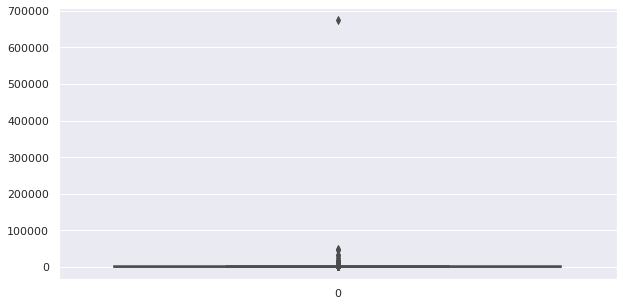

In [9]:
# Изучим структуру стоимости заказов
sns.boxplot(data=data_orders['total_revenue'])
data_orders['total_revenue'].max() #самый дорогой заказ, выяснили у источника данных что это тестовый заказ, уберем его из анализа
data_orders = data_orders[(data_orders['order_id']!=71743)]
data = data[(data['order_id']!=71743)]

<AxesSubplot:>

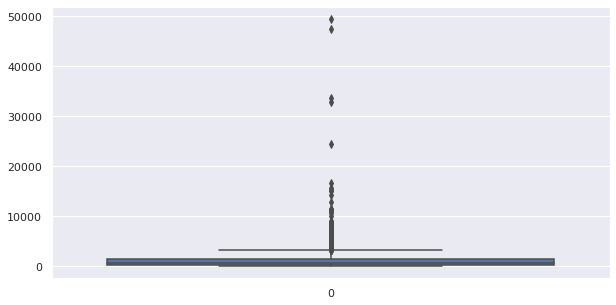

In [10]:
# Посмотрим распределение суммы стоимости заказов после удаление слишком большого заказа
sns.boxplot(data=data_orders['total_revenue'])

Дубликаты и выбросы убраны, данные готовы к исследовательскому анализу

### Исследовательский анализ данных

In [11]:
data_orders.head(1)

,date,customer_id,order_id,year,month_year,month,week,day,week_day,hour,quantity,total_revenue
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,2018,2018-10,10,40,2018-10-01,0,0,7,1037.0


In [12]:
print('Количество заказов:',data['order_id'].nunique())
print('Количество покупателей:',data['customer_id'].nunique())

Количество заказов: 2783
Количество покупателей: 2422


In [13]:
print('Минимальная дата в данных:',min(data_orders['date']))
print('Максимальная дата в данных:',max(data_orders['date']))

Минимальная дата в данных: 2018-10-01 00:00:00
Максимальная дата в данных: 2019-10-31 16:00:00


In [14]:
# Посмотрим распредление по годам
data.groupby('year')['customer_id','order_id'].nunique()

,customer_id,order_id
year,,
2018,585,721
2019,1843,2063


Данные представлены за последние 3 месяца 2018 года и по октябрь 2019 года. Будем рассматривать показатели в динамике по колонке год+месяц

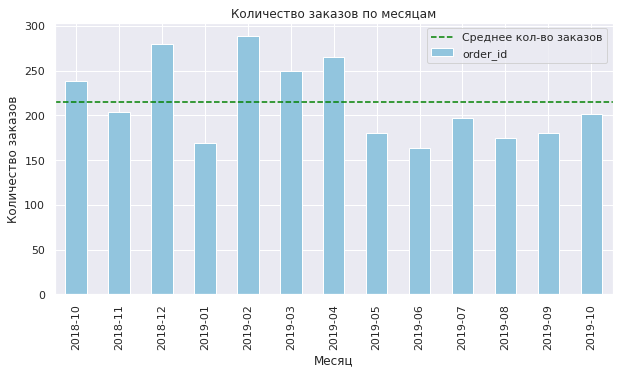

In [15]:
# Столбчатый график с кол-вом заказов по месяцам
group_data = data_orders.groupby('month_year')['order_id'].nunique().reset_index()
group_data.plot('month_year','order_id', kind='bar', color ='#92c5de') 
plt.axhline(y=np.nanmean(group_data['order_id']),color='green', linestyle='--', linewidth=1.5, label='Среднее кол-во заказов')
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.title('Количество заказов по месяцам')
plt.legend()
plt.show()

Изучая динамику количества заказов по месяцам, заметен небольшой тренд на снижение кол-ва заказов в 2019 году. Количество заказов в месяц с мая 2019 года ниже среднего ежемесячного кол-ва заказов за весь период. В январе также заметен спад количества заказов, который может быть обусловлен покупательской стагнацией после новогодних затрат.

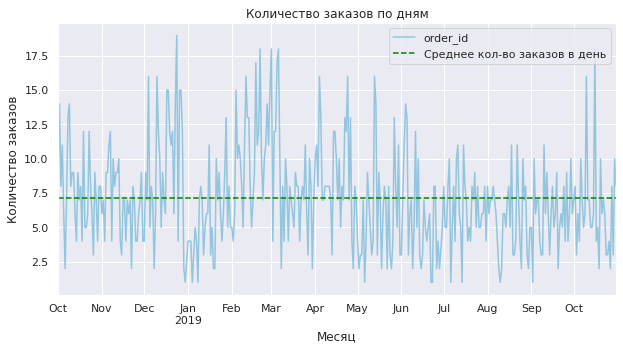

In [16]:
# Линейный график с кол-вом заказов по дням
group_data = data_orders.groupby('day')['order_id'].nunique().reset_index()
group_data.plot('day','order_id', color ='#92c5de') 
plt.axhline(y=np.nanmean(group_data['order_id']),color='green', linestyle='--', linewidth=1.5, label='Среднее кол-во заказов в день')
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.title('Количество заказов по дням')
plt.legend()
plt.show()

Снижение заказов также заметно в разбивке динамики по дням. Чаще всего со второго квартала 2019 года кол-во заказов стало меньше среднего кол-ва за весь период.

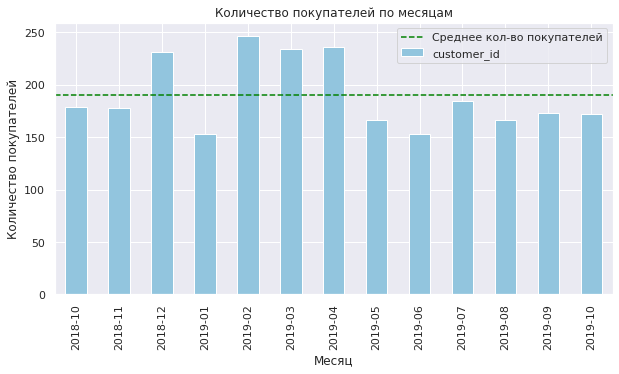

In [17]:
# Столбчатый график с кол-вом покупателей по месяцам
group_data = data_orders.groupby('month_year')['customer_id'].nunique().reset_index()
group_data.plot('month_year','customer_id', kind='bar', color ='#92c5de') 
plt.axhline(y=np.nanmean(group_data['customer_id']),color='green', linestyle='--', linewidth=1.5, label='Среднее кол-во покупателей')
plt.xlabel('Месяц')
plt.ylabel('Количество покупателей')
plt.title('Количество покупателей по месяцам')
plt.legend()
plt.show()

Количество покупателей повторяет тенденцию показателя количества заказов: с мая 2019 кол-во покупателей уменьшилось и было ниже среднего показателя за весь период.

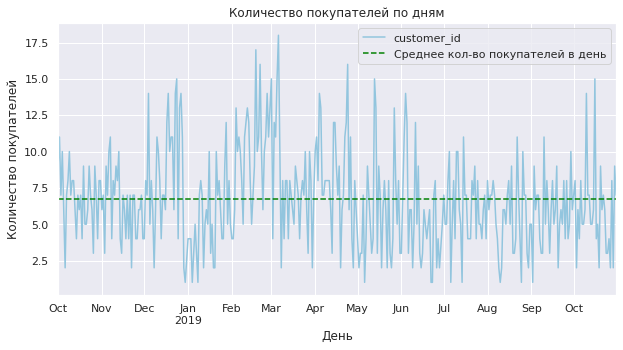

In [18]:
# Линейный график с кол-вом покупателей по дням
group_data = data_orders.groupby('day')['customer_id'].nunique().reset_index()
group_data.plot('day','customer_id', color ='#92c5de') 
plt.axhline(y=np.nanmean(group_data['customer_id']),color='green', linestyle='--', linewidth=1.5, label='Среднее кол-во покупателей в день')
plt.xlabel('День')
plt.ylabel('Количество покупателей')
plt.title('Количество покупателей по дням')
plt.legend()
plt.show()

Динамика по дням показателя количества покупателей также повторяет снижение активности с мая 2019 г.

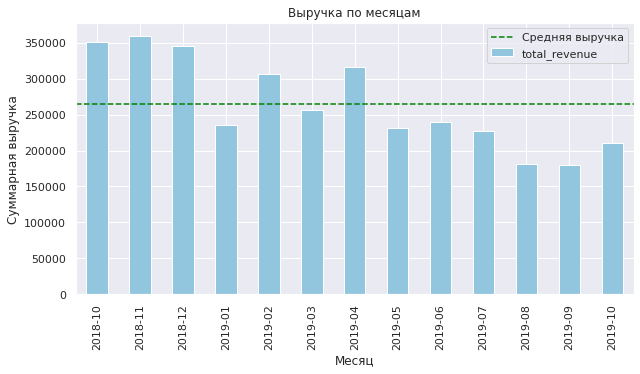

In [19]:
# Столбчатый график с выручкой по месяцам
group_data = data_orders.groupby('month_year')['total_revenue'].sum().reset_index()
group_data.plot('month_year','total_revenue', kind='bar', color ='#92c5de') 
plt.axhline(y=np.nanmean(group_data['total_revenue']),color='green', linestyle='--', linewidth=1.5, label='Средняя выручка')
plt.xlabel('Месяц')
plt.ylabel('Суммарная выручка')
plt.title('Выручка по месяцам')
plt.legend()
plt.show()

Анализируя динамику выручки магазина, ежемесячная выручка значительно уменьшается к концу 2019 года. Падение показателя сильнее заметно, чем уменьшение количества заказов и клиентов, что возможно говорит о введении большого кол-ва скидочных программ и акций для восстановления покупательской активности. 

В октябре 2019 года выручка уменьшилась на 37,6% по сравнению с октябрем 2018. Наибольшая выручка в 2019 году была в апреле.

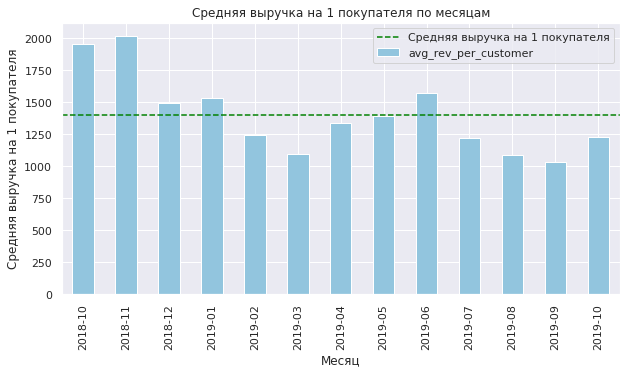

In [20]:
# Cредняя выручка на 1 покупателя по месяцам
rev_per_month = data_orders.groupby('month_year')['total_revenue','customer_id'].agg({'total_revenue':'sum',
                                                                       'customer_id':'nunique' }).reset_index()
rev_per_month['avg_rev_per_customer'] = round(rev_per_month['total_revenue']/rev_per_month['customer_id'])

rev_per_month.plot('month_year','avg_rev_per_customer', kind='bar', color ='#92c5de') 
plt.axhline(y=np.nanmean(rev_per_month['avg_rev_per_customer']),color='green', linestyle='--', linewidth=1.5, label='Средняя выручка на 1 покупателя')
plt.xlabel('Месяц')
plt.ylabel('Средняя выручка на 1 покупателя')
plt.title('Средняя выручка на 1 покупателя по месяцам')
plt.legend()
plt.show()

Относительный показатель средней выручки на 1 покупателя имеет более сглаженный вид по сравнению с общим значением выручки: также наблюдаются уменьшение денег в обороте, средняя выручка на 1 покупателя в октябре 2019 упала на 38% по сравнению с октябрем 2018.

В 2019 году наибольший показатель средней выручки на 1 покупателя пришелся на июнь (когда было меньше всего покупателей).

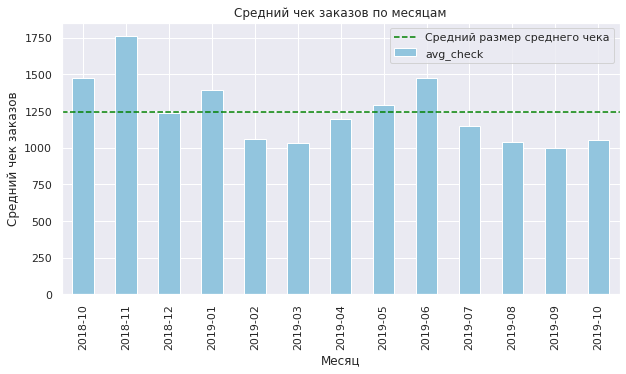

In [21]:
# Cредний чек заказов
check_per_month = data_orders.groupby('month_year')['total_revenue','order_id'].agg({'total_revenue':'sum',
                                                                       'order_id':'nunique' }).reset_index()
check_per_month['avg_check'] = round(check_per_month['total_revenue']/check_per_month['order_id'])

check_per_month.plot('month_year','avg_check', kind='bar', color ='#92c5de') 
plt.axhline(y=np.nanmean(check_per_month['avg_check']),color='green', linestyle='--', linewidth=1.5, label='Средний размер среднего чека')
plt.xlabel('Месяц')
plt.ylabel('Средний чек заказов')
plt.title('Средний чек заказов по месяцам')
plt.legend()
plt.show()

Динамика среднего чека также имеет тенденцию к снижению. Наибольший показатель в 2019 году приходит на июнь 2019.

В октябре 2019 средний чек уменьшился на 26% по сравнению с октябрем 2018 года.

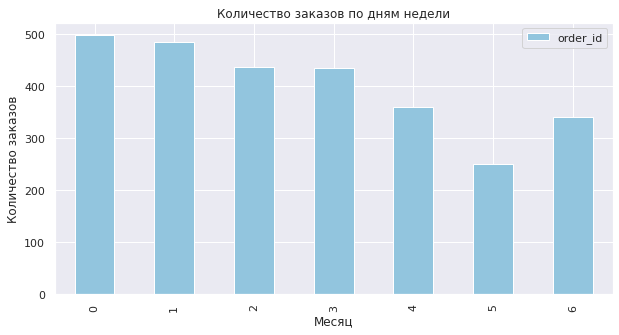

In [22]:
# В какой день недели делают больше всего заказов
group_data = data_orders.groupby('week_day')['order_id'].nunique().reset_index() # 0 - понедельник, 6 - воскресенье
group_data.plot('week_day','order_id', kind='bar', color ='#92c5de') 
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.title('Количество заказов по дням недели')
plt.show()

Больше всего заказов было сделано в начале недели, меньше всего заказов пришлось на субботу. В выходные клиенты больше отдыхают, чем совершают покупки в онлайн магазине товаров для дома.

In [23]:
# Посмотрим есть ли у клиентов повторные заказы
few_orders = data_orders.groupby('customer_id')['order_id'].nunique().reset_index().sort_values(by='order_id',ascending = False)
few_orders = few_orders.groupby('order_id')['customer_id'].nunique().reset_index()
few_orders['share'] = round(few_orders['customer_id']/data['customer_id'].nunique()*100,2)
few_orders = few_orders.rename(columns ={'order_id':'кол-во заказов',
                                        'customer_id':'кол-во клиентов',
                                        'share':'доля от всех клиентов'})
few_orders

,кол-во заказов,кол-во клиентов,доля от всех клиентов
0,1,2265,93.52
1,2,129,5.33
2,3,20,0.83
3,4,3,0.12
4,5,1,0.04
5,7,1,0.04
6,17,1,0.04
7,35,1,0.04
8,126,1,0.04


Из 2450 покупателей, только 160 совершали повторную покупку (6,5%).

93,5 % клиентов совершили за 13 месяцев только 1 покупку.

Магазину нужно обратить внимание на удержание и возвращение спящих клиентов.

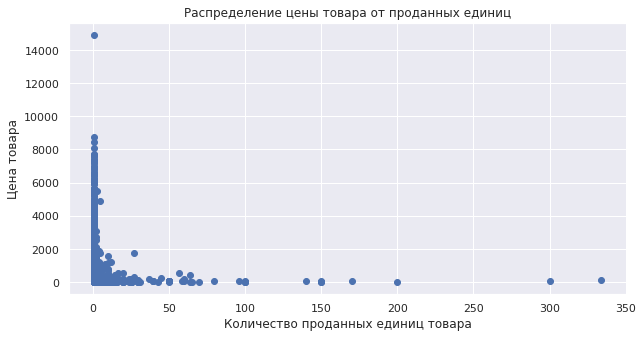

          quantity     price
quantity  1.000000 -0.065114
price    -0.065114  1.000000


In [24]:
# Точечная диаграмма цена-проданные шт
plt.scatter(data['quantity'],data['price'])
plt.xlabel('Количество проданных единиц товара')
plt.ylabel('Цена товара')
plt.title('Распределение цены товара от проданных единиц')
plt.show()

# Корреляция Пирсона
print(data[['quantity','price']].corr())

На графике видно, что больше всего продано единиц у недорогостоящих товаров, тем временем у дорогих позиций кол-во проданных единиц меньше 10. Дорогостоющие товары для дома люди скорее всего предпочитают приобретать очно. (Однако статистической зависимости между кол-вом проданных товаров и их ценой не наблюдается).

Также возможно стоит обратить внимание на контентную состовляющую оформления карточки товара: обеспечить набором качественных фотографий товара, дополнительным видео материалом, полным описанием и достаточным количеством отзывов, чтобы повысить уверенность покупателя в качестве товара и увеличить продажи дорогих позиций.

In [25]:
# Самые продаваемые товары
top_10_good = data.groupby(['product','price'])['quantity'].sum().reset_index().sort_values(by='quantity', ascending = False).head(10)
print('10 самых продаваемых товаров')
display(top_10_good)

10 самых продаваемых товаров


,product,price,quantity
934,Муляж ЯБЛОКО 9 см красное,51.0,470
217,Вешалки мягкие для деликатных вещей 3 шт шоколад,148.0,334
1645,"Ручка-скоба РС-100 белая *Трибатрон*, 1108035",29.0,200
748,"Крепеж для пружины дверной, 1107055",19.0,150
1271,Плечики пластмассовые Размер 52 - 54 Тула 1205158,20.0,150
1366,Пружина дверная 240 мм оцинкованная (Д-19 мм) ...,38.0,150
935,Муляж ЯБЛОКО 9 см красное,59.0,148
938,Муляж Яблоко зеленый 9 см полиуретан,59.0,113
2507,Щетка для мытья посуды КОЛИБРИ М5202 большая,34.0,100
747,"Крепеж для пружины дверной оцинкованный, 1107054",19.0,100


In [26]:
# Товары с 1 продажей
top_soso = data.groupby(['product','price'])['quantity'].sum().reset_index().sort_values(by='quantity', ascending = True)
top_soso[top_soso['quantity']==1]

,product,price,quantity
0,Tepмокружка AVEX Freeflow 700 мл зеленый AVEX0759,2399.0,1
1574,"Рассада томата (помидор) сорт Золотое руно, ка...",116.0,1
1573,Рассада томата (помидор) сорт Зефир в шоколаде...,45.0,1
1565,Рассада томата (помидор) Моравское чудо №54 со...,38.0,1
1561,Рассада томата (помидор) Баскью Блю №7 сорт де...,38.0,1
...,...,...,...
16,Азалия Индика Биколор d-12 см h-20,344.0,1
594,Коврик для туалета L'CADESI HURREM 50х60 см с ...,389.0,1
507,Калибрахоа Bloomtastic Blossom розово-сиренева...,90.0,1
595,"Коврик интерьерный 45х75 Вино Comfort Mats, Mo...",974.0,1


Самыми продаваемыми товарами на сайте стали дешевые товары стоимостью до 150 рублей. При этом 1314 товаров было проданы лишь 1 раз.

Предположим, что падение активности связано с сезонностью, например в декабре спрос на продукцию товаров для дома растет из-за новогодних праздников, в конце зимы и начале весны повышен спрос на растения и рассаду, а также на товары для подготовки к дачному сезону, летом спрос может падать из-за отпускных недель.

К сожалению, для подтверждения сезонности нужен второй (а лучше несколько) периодов для сравнения. 
Сравнив октябрь 2018 и октябрь 2019 все указывает на снижение покупательской активности: 
* количество покупателей уменьшилось на 2% (на 4 клиента)
* количество заказов сократилось на 15 % (на 37 заказа)
* выручка сократилась на 37,6% (на 132 тыс. руб.)
* средний чек уменьшился на 26% (на 385 руб.)

Можно сделать вывод о том, что во всех бизнес показателях магазин «Пока все ещё тут» (оправдывает свое название - шутка для ревьювера) уступает прошлому периоду.

Только 6,5% клиентов совершали повторную покупку в течение 13 месяцев, это значит что 93,5% (2290 клиента) сделали только 1 заказ.

Самые продаваемые товары стали товары из дешевого сегмента.

### Сегментация покупателей на основе истории их покупок

Определим каждому клиенту категории по ранее подчитанным показателям

In [27]:
# Разделение на кол-во заказов (1, 2, более 3)
data_customers = data_orders.groupby('customer_id')['order_id'].nunique().reset_index().sort_values(by='order_id')
data_customers['type_orders_quantity'] = ''

#проставим названия группам клиентов в зависимости от кол-ва закозов
data_customers.loc[data_customers['order_id']==1,'type_orders_quantity'] = 'мало' 
data_customers.loc[data_customers['order_id']==2,'type_orders_quantity'] = 'средне'
data_customers.loc[data_customers['order_id']>=3,'type_orders_quantity'] = 'много'
data_customers.groupby('type_orders_quantity')['customer_id'].nunique()

type_orders_quantity
мало      2265
много       28
средне     129
Name: customer_id, dtype: int64

Резделим клиентов на 3 категории по кол-ву созданных заказов: 
* "мало" заказов присвоим за 1 заказ (2290 клиентов, 93,5%)
* "средне" заказов присвоим за 2 заказа (132 клиентов, 5,5%)
* "много" заказов присвоим за больше 3х заказов (28 клиентов, 1%)

In [28]:
#Разделение на средние чеки заказов (низкий, средний, высокий)
data_avg_check = data_orders.groupby('customer_id')['total_revenue','order_id'].agg({'total_revenue':'sum',
                                                                                     'order_id':'nunique' }).reset_index()
data_avg_check['avg_check'] = round(data_avg_check['total_revenue']/data_avg_check['order_id'])
data_avg_check['type_avg_check'] = ''

# sns.boxplot(data=data_avg_check['avg_check']) #выбор значений
# data_avg_check['avg_check'].describe()

#проставим названия группам клиентов в зависимости от размера среднего чека
data_avg_check.loc[data_avg_check['avg_check']<=300,'type_avg_check'] = 'низкий' 
data_avg_check.loc[(data_avg_check['avg_check']>300)&(data_avg_check['avg_check']<1500),'type_avg_check'] = 'средний'
data_avg_check.loc[data_avg_check['avg_check']>=1500,'type_avg_check'] = 'высокий'
data_avg_check.groupby('type_avg_check')['customer_id'].nunique()

type_avg_check
высокий     584
низкий      646
средний    1192
Name: customer_id, dtype: int64

Резделим клиентов на 3 категории по размеру суммы среднего чека: 
* "низкий" средний чек присвоим за чек меньше или равно 300 руб. (656 клиентов, 27%)
* "средний" средний чек присвоим за чек от 300 до 1500 руб. (1205 клиентов, 49%)
* "высокий" средний чек присвоим за чек больше 1500 руб. (589 клиентов, 24%)

In [29]:
# Разделение на среднее кол-во товаров в чеке (мало, средний, высокий)
data_order_quantity = data_orders.groupby('customer_id')['quantity','order_id'].agg({'quantity':'sum',
                                                                                     'order_id':'nunique' }).reset_index()
data_order_quantity['avg_quantity'] = round(data_order_quantity['quantity']/data_order_quantity['order_id'])
data_order_quantity['type_sku_avg_quantity'] = ''

# sns.boxplot(data=data_order_quantity['avg_quantity']) #выбор значений
# data_order_quantity['avg_quantity'].describe()

#проставим названия группам клиентов в зависимости от среднего кол-ва товаров в заказе
data_order_quantity.loc[data_order_quantity['avg_quantity']==1,'type_sku_avg_quantity'] = 'мало' 
data_order_quantity.loc[(data_order_quantity['avg_quantity']>=2)&(data_order_quantity['avg_quantity']<=4),'type_sku_avg_quantity'] = 'средне'
data_order_quantity.loc[data_order_quantity['avg_quantity']>=5,'type_sku_avg_quantity'] = 'много'
data_order_quantity.groupby('type_sku_avg_quantity')['customer_id'].nunique()

type_sku_avg_quantity
мало      1543
много      441
средне     438
Name: customer_id, dtype: int64

Резделим клиентов на 3 категории по среднему количеству товаров в чеке: 
* "мало" товаров присвоим за 1 товар (1562 клиентов, 64%)
* "средне" товаров присвоим за 2-4 товара (442 клиентов, 18%)
* "много" товаров присвоим за больше 5 товаров (446 клиентов, 18%)

На основе описательной статистики мы вручную присвоили сегменты клиентам по трем показателям: количество заказов, средний чек, среднее количество товаров в заказе. В дальнейшем можно корректировать условия попадания в ту или иную группу, а также возможно увеличить с трех сегментов до четырех и тп. 

На данный момент можно уже работать с отобранными группами, например обратить на клиентов с высоким средним чеком и большим количеством заказов или же наоборот прислать рассылку с промокодом покупателям, которые покупали 1 раз, но много товаров.

Для определения точного сегмента проведем кластерный анализ.

#### Проведем кластерный анализ методом kmean

Для формирования кластеров будем использовать количественные колонки и алгоритм k-средних (k-means)

In [30]:
# Соединим в 1 датасет предыдущие наши расчеты
cluster_gen = data_avg_check.merge(data_order_quantity, how='left', on='customer_id')

#оставляем только числовые значения
cluster = cluster_gen[['order_id_x', 'total_revenue', 'avg_check','quantity', 'avg_quantity']]
cluster.head(2)

,order_id_x,total_revenue,avg_check,quantity,avg_quantity
0,1,555.0,555.0,4,4.0
1,1,442.0,442.0,1,1.0


In [31]:
dataNorm = preprocessing.MinMaxScaler().fit_transform(cluster.values) #приведем данные к нормальным значениям

# Вычисляется евклидово расстояние
data_dist = pdist(dataNorm, 'euclidean')

data_linkage = linkage(data_dist, method='average')

#функция построения дендрограмм
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Дендрограмма иерархической кластеризации (усеченная)')
        plt.xlabel('Кластеры')
        plt.ylabel('Растояние')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

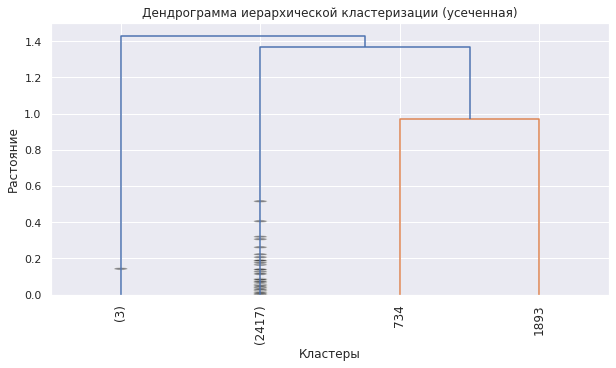

In [32]:
nClust=4 #количество кластеров (Так как у нас есть несколько клиентов с особенным поведением, выберем 4 кластера вместо 3х)

#строим дендрограмму 
fancy_dendrogram(
    data_linkage,
    truncate_mode='lastp',
    p=nClust, 
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10)
plt.show()

In [33]:
# строим кластеризаци методом KMeans
km = KMeans(n_clusters=nClust).fit(dataNorm)
cluster['cluster']=km.labels_+1
cluster.head(5)

,order_id_x,total_revenue,avg_check,quantity,avg_quantity,cluster
0,1,555.0,555.0,4,4.0,1
1,1,442.0,442.0,1,1.0,1
2,1,914.0,914.0,2,2.0,1
3,1,1649.0,1649.0,1,1.0,1
4,1,2324.0,2324.0,2,2.0,1


Изучим показатели по каждому кластеру каждой метрики.

In [34]:
cluster_table = cluster.groupby('cluster')[('order_id_x','avg_check','avg_quantity')].agg({'order_id_x':['count','min','max','mean'],
                                                                                            'avg_check':['min','max','mean'],
                                                                                            'avg_quantity':['min','max','mean']}).round()
cluster_table = cluster_table.rename(columns ={'order_id_x':'кол-во заказов',
                                                'avg_check':'средний чек',
                                                'avg_quantity':'среднее кол-во товаров в заказе'})
cluster_table

кол-во заказов                средний чек                    \
                 count min  max  mean         min      max     mean   
cluster                                                               
1                 2357   1   17   1.0        14.0   8810.0   1061.0   
2                   59   1    7   1.0       540.0  33680.0   6704.0   
3                    2  35  126  80.0      1266.0   1637.0   1452.0   
4                    4   1    1   1.0      5800.0  49432.0  19770.0   

        среднее кол-во товаров в заказе                
                                    min    max   mean  
cluster                                                
1                                   1.0   34.0    3.0  
2                                   1.0  170.0   49.0  
3                                   3.0    9.0    6.0  
4                                 200.0  334.0  284.0

В результате кластерного анализа у нас получилось 4 кластера. Из минусов: они неравномерные по кол-ву клиентов, из плюсов: в расчетах присутсвует комбинация из всех метрик.

1 кластер — уверенный средний чек и много товаров в заказе (4,7%, 117 клиентов):
* Кол-во заказов от 1 до 7
* Высокий средний чек от 475 руб. до 32718 руб. (в среднем 4140 руб.)
* Среднее кол-во товаров в заказе от 1 до 100 (в среднем 33)

Клиенты из этого кластера более привлекательны с точки зрения увеличения выручки, возможно их можно взбодрить интерактивной рассылкой или запуском программы лояльности (например с накопительными бонусами)

2 кластер — мало заказов, но много товаров (0,3% , 8 клиентов):
* Совершили 1 покупку
* Высокий средний чек от 3000 руб. до 49432 руб. (в среднем 16586 руб.)
* Среднее кол-во товаров в заказе от 101 до 334 (в среднем 212)

Поведение этих покупателей похоже на поведение оптовиков. К сожалению, они не вернулись за повторной покупкой, возможно стоит обратить внимание на специальные клиентские карты для юр. лиц, дающие возможность покупать по оптовым ценам.

3 кластер — супер лояльные физики или малый бизнес (2 клиента):
* Кол-во заказов от 35 до 126
* Средний чек от 1266 до 1637 руб. (в среднем 1452 руб.)
* Среднее кол-во товаров в заказе от 1 до 23 (в среднем 2)

Кластер состоит из двух клиентов, которые чаще всего покупали много товаров. Средний чек у них низковат, в целом можно их добавить к 3 кластеру.

4 кластер — средний и самый многочисленный (95% клиентов):
* Кол-во заказов от 1 до 17
* Низкий средний чек от 14 руб. до 8758 руб. (в среднем 1026 руб.)
* Среднее кол-во товаров в заказе от 1 до 23 (в среднем 2)

Кластер описывает среднее поведение основной части клиентов. С такими клиентами нужно работать для повышения LTV.

In [35]:
# Соберем финальнкую таблицу сегментов клиентов
cluster_final = cluster_gen.merge(data_customers, how='left', on='customer_id')
cluster_final = cluster_final.merge(cluster, how='left', left_index=True, right_index=True)
cluster_final = cluster_final[['customer_id','order_id','type_orders_quantity','avg_check_x','type_avg_check', 'avg_quantity_x','type_sku_avg_quantity','cluster']]
cluster_final = cluster_final.rename(columns ={'order_id':'orders_quantity', #кол-во заказов
                                               'avg_check_x':'avg_check', #средний_чек
                                               'avg_quantity_x':'sku_avg_quantity' #среднее кол-во товаров в заказе
                                              })
                                                #type_orders_quantity #Параметр: кол-во заказов
                                                #type_avg_check #Параметр: размер среднего чека
                                                #type_sku_avg_quantity #Параметр: кол-во товаров в заказе
cluster_final.head(5)

,customer_id,orders_quantity,type_orders_quantity,avg_check,type_avg_check,sku_avg_quantity,type_sku_avg_quantity,cluster
0,000d6849-084e-4d9f-ac03-37174eaf60c4,1,мало,555.0,средний,4.0,средне,1
1,001cee7f-0b29-4716-b202-0042213ab038,1,мало,442.0,средний,1.0,мало,1
2,00299f34-5385-4d13-9aea-c80b81658e1b,1,мало,914.0,средний,2.0,средне,1
3,002d4d3a-4a59-406b-86ec-c3314357e498,1,мало,1649.0,высокий,1.0,мало,1
4,003bbd39-0000-41ff-b7f9-2ddaec152037,1,мало,2324.0,высокий,2.0,средне,1


В итоге у нас есть более ручной, настраваемый и комбинированный вариант сегментации, состоящий из трех показателей, который можно самостоятельно составлять по запросу коллег и вторая кластерная сегментация, которая полноценна выделила 4 группы клиентов со схожими покупательскими патернами. 

На основе проставленных категорий можно выбрать комбинации и составить сегмент:
например люди с высоким средним чеком и с большим числом заказов — состоятельный сегмент которому интересны качественные дорогостоющие товары, или покупатель с 1 крупным заказом — теплый клиент, нужно ему прислать пуш на повторную покупку. 

Проверим статистически несколько сегментов.

### Проверка статистических гипотез

Проверим, действительно ли в выбранных группах и кластерах есть различия, будет ли отличие между несколькими выбранными группами статистически достоверным (гипотеза о равенстве средний двух генеральных совокупностей).

Для проверки выборок будем использовать t-test (в параметре equal_var укажим False, так как у нас разные размеры сравниваемых выборок)

type_orders_quantity orders_quantity мало


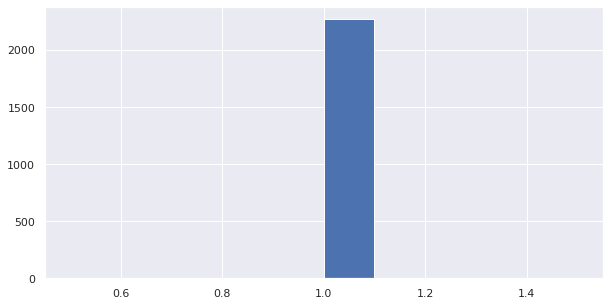

type_orders_quantity orders_quantity много


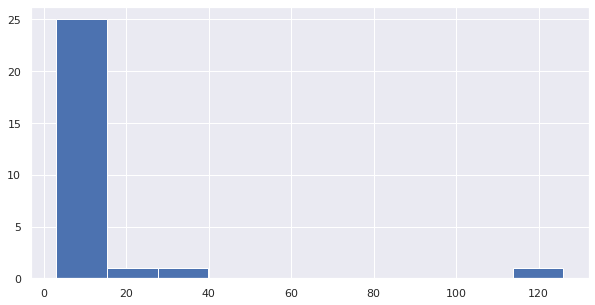

type_orders_quantity orders_quantity средне


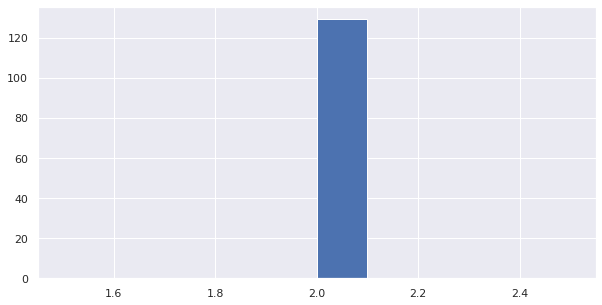

type_orders_quantity avg_check мало


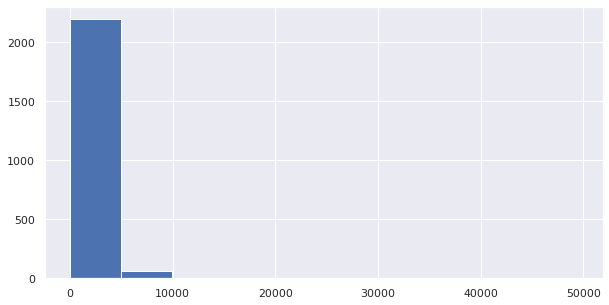

type_orders_quantity avg_check много


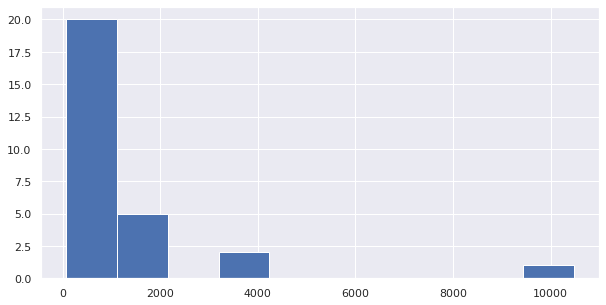

type_orders_quantity avg_check средне


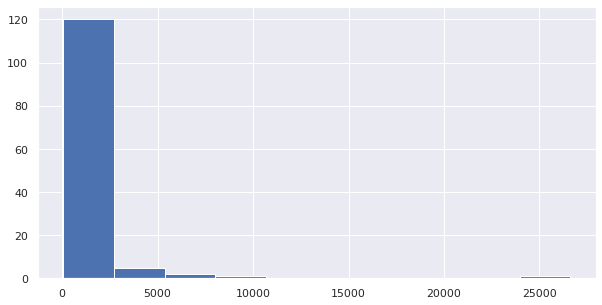

type_orders_quantity sku_avg_quantity мало


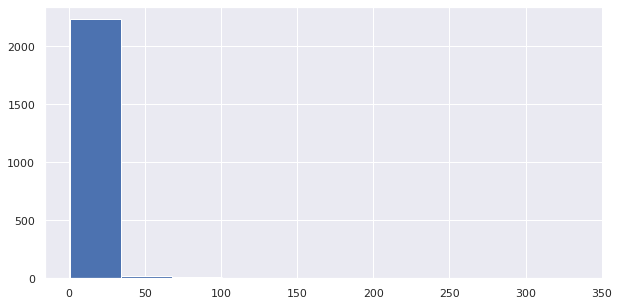

type_orders_quantity sku_avg_quantity много


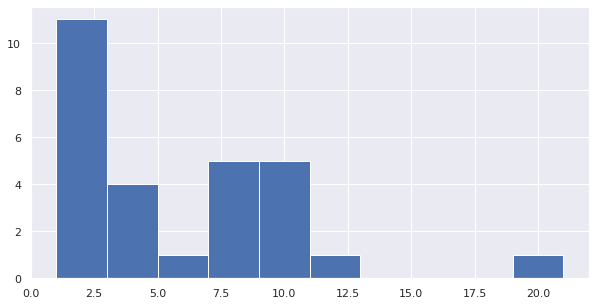

type_orders_quantity sku_avg_quantity средне


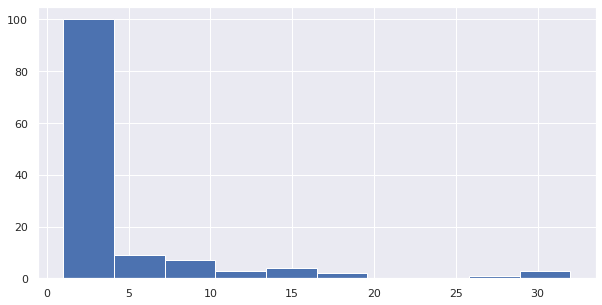

type_avg_check orders_quantity средний


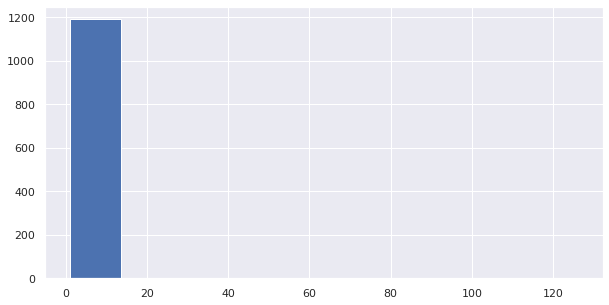

type_avg_check orders_quantity высокий


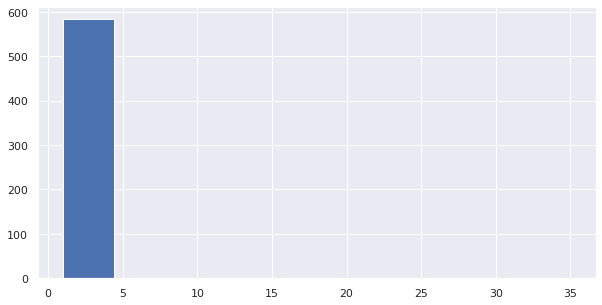

type_avg_check orders_quantity низкий


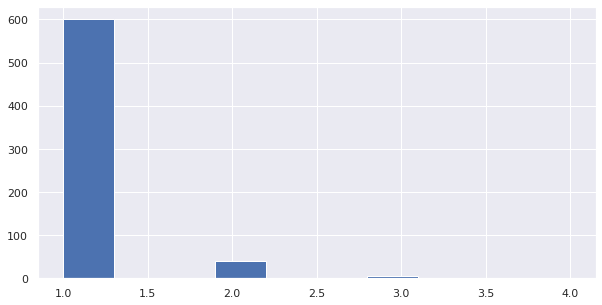

type_avg_check avg_check средний


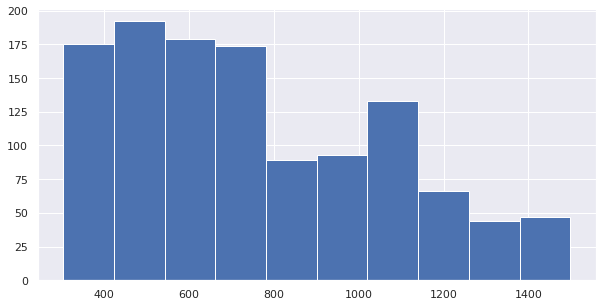

type_avg_check avg_check высокий


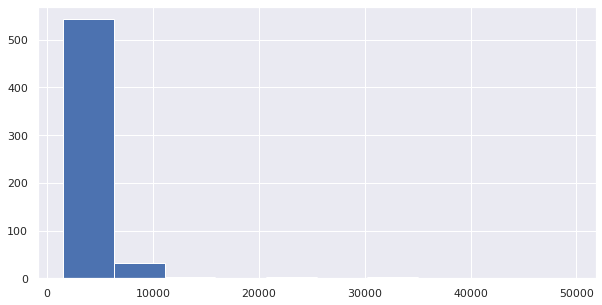

type_avg_check avg_check низкий


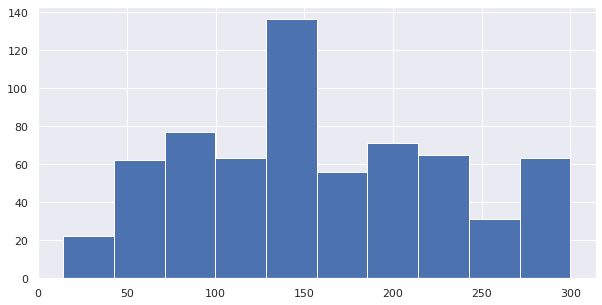

type_avg_check sku_avg_quantity средний


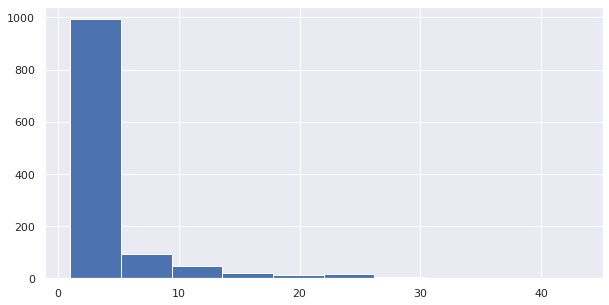

type_avg_check sku_avg_quantity высокий


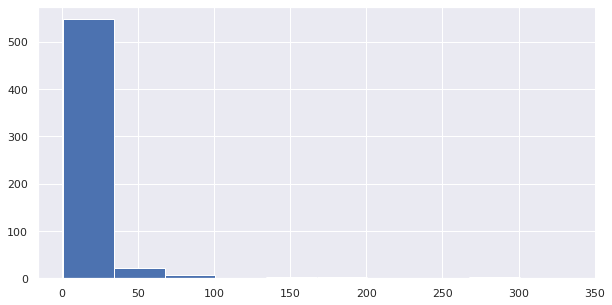

type_avg_check sku_avg_quantity низкий


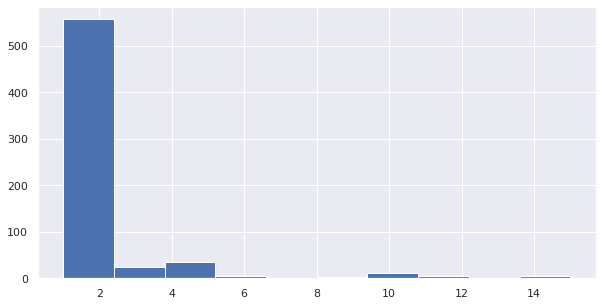

type_sku_avg_quantity orders_quantity средне


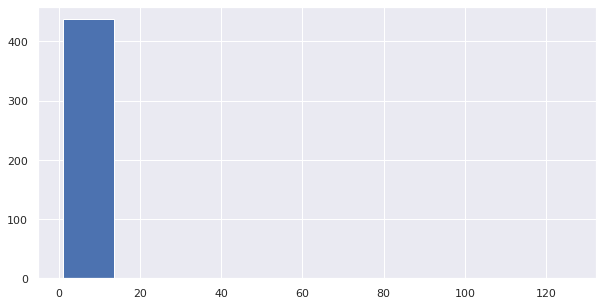

type_sku_avg_quantity orders_quantity мало


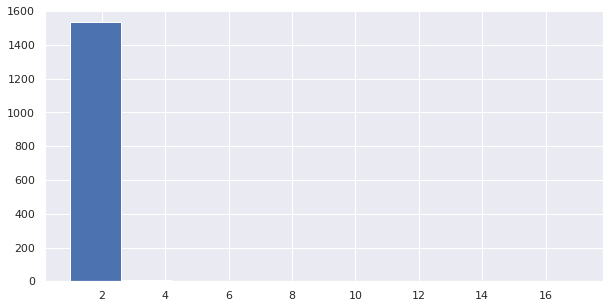

type_sku_avg_quantity orders_quantity много


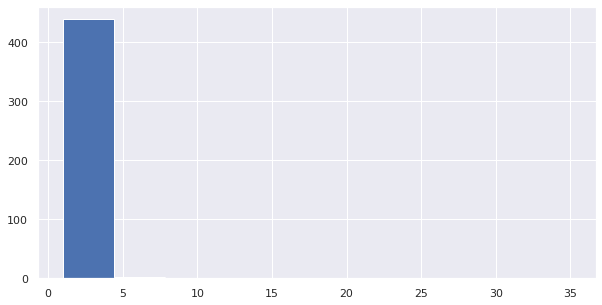

type_sku_avg_quantity avg_check средне


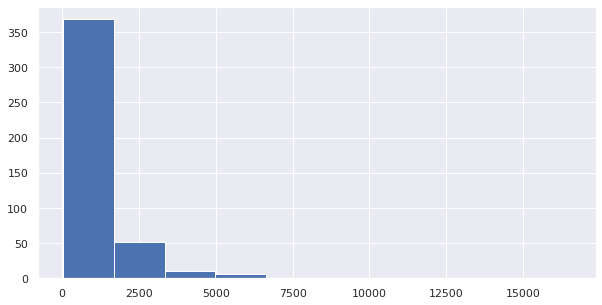

type_sku_avg_quantity avg_check мало


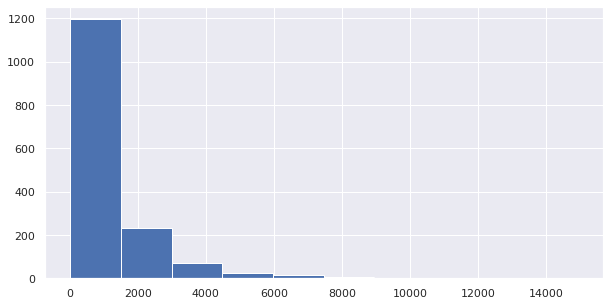

type_sku_avg_quantity avg_check много


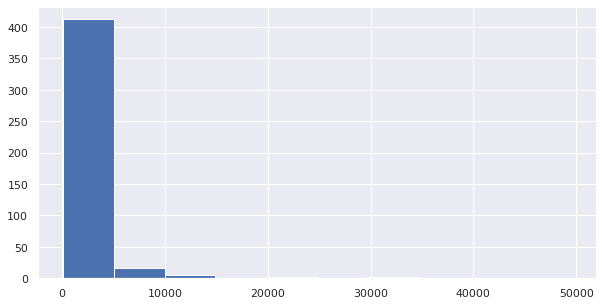

type_sku_avg_quantity sku_avg_quantity средне


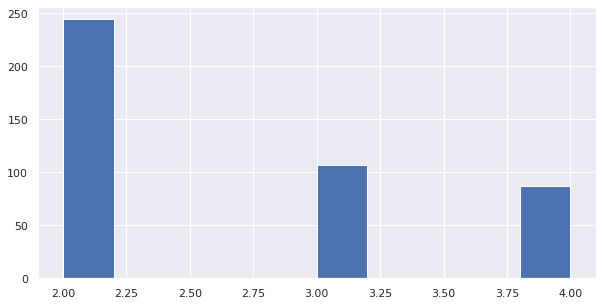

type_sku_avg_quantity sku_avg_quantity мало


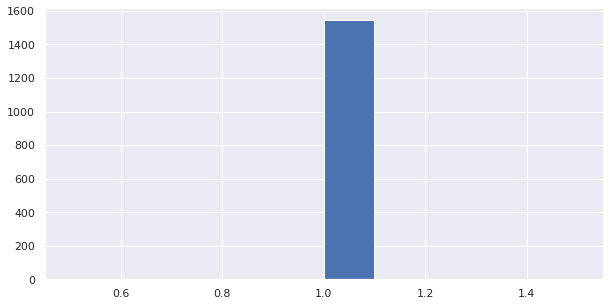

type_sku_avg_quantity sku_avg_quantity много


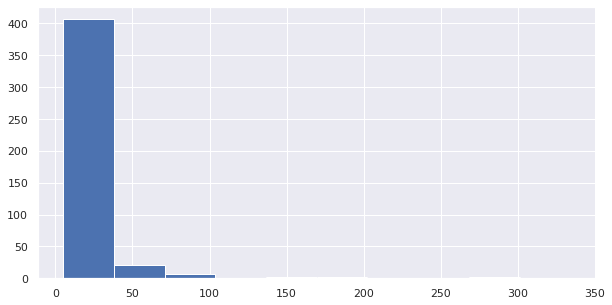

cluster orders_quantity 1


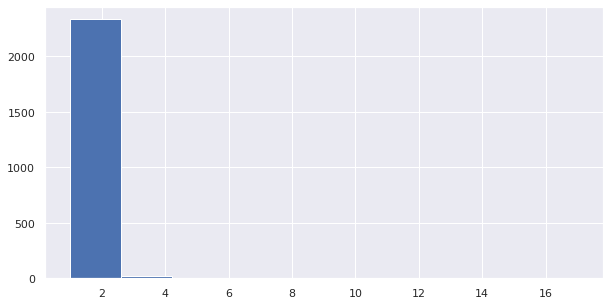

cluster orders_quantity 2


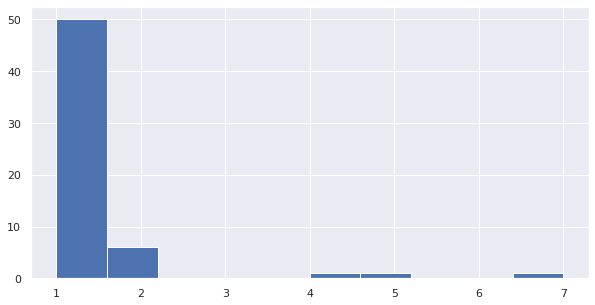

cluster orders_quantity 4


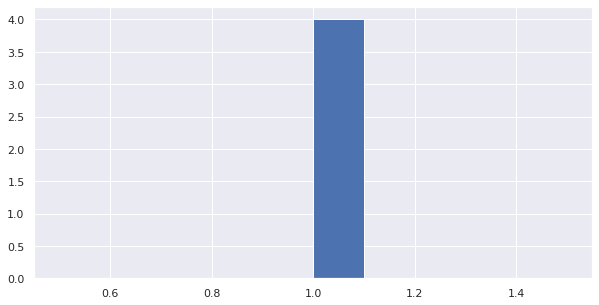

cluster orders_quantity 3


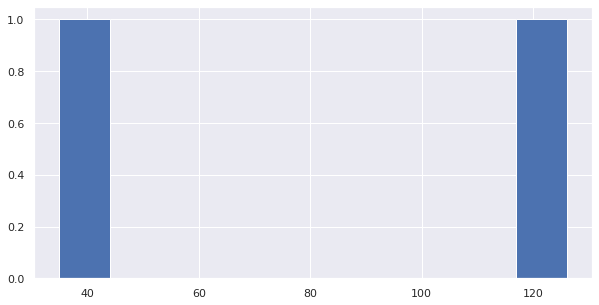

cluster avg_check 1


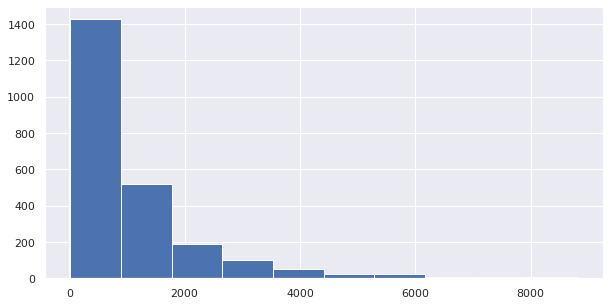

cluster avg_check 2


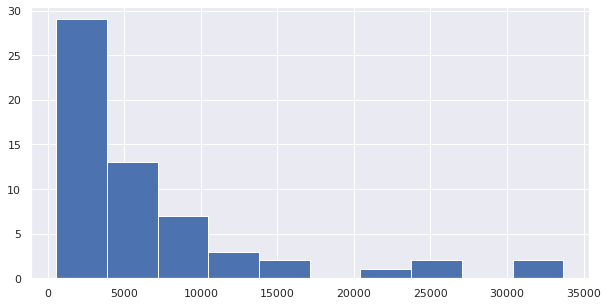

cluster avg_check 4


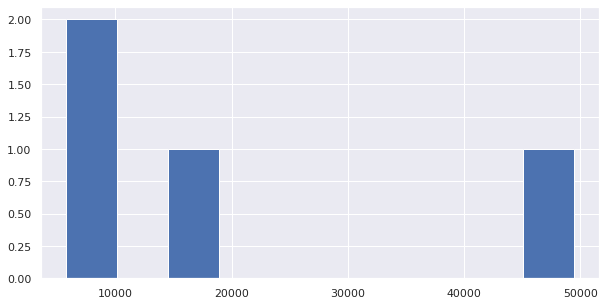

cluster avg_check 3


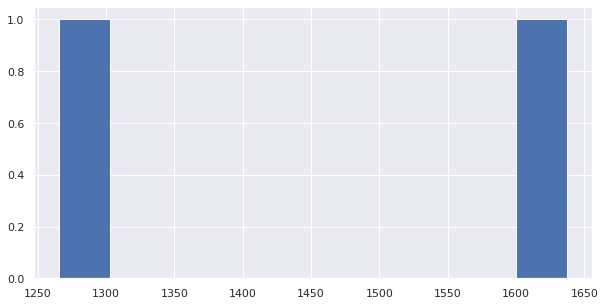

cluster sku_avg_quantity 1


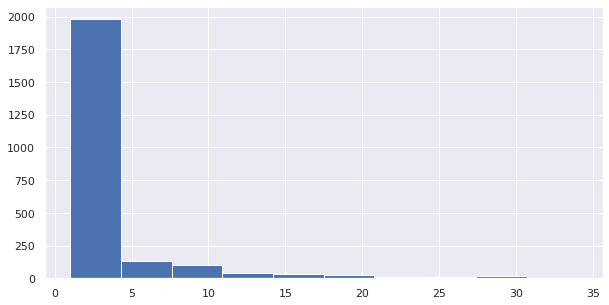

cluster sku_avg_quantity 2


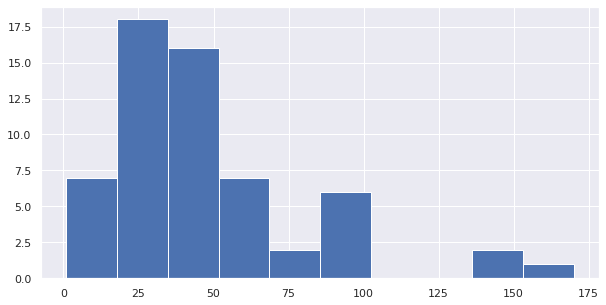

cluster sku_avg_quantity 4


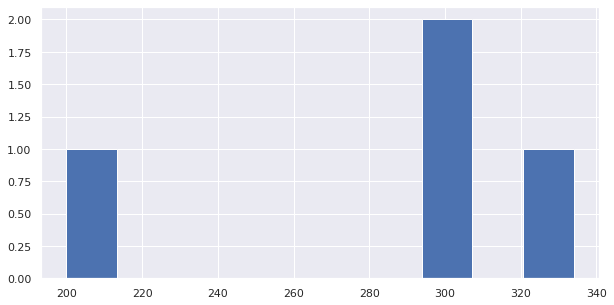

cluster sku_avg_quantity 3


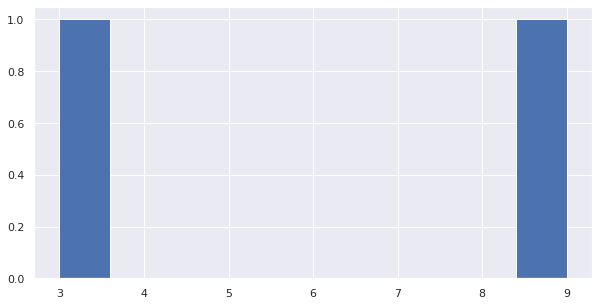

In [36]:
# #проверим данные на нормальность, чтобы в дальнейшем использовать t_test

type_group = ['type_orders_quantity','type_avg_check','type_sku_avg_quantity', 'cluster']
parametrs = ['orders_quantity','avg_check','sku_avg_quantity']

for group in type_group: 
    for parametr in parametrs:
        variants = cluster_final[group].unique()
        for variant in variants: 
            cluster_final[cluster_final[group]== variant][parametr].hist()
            print(group, parametr, variant)
            plt.show()
# данные распределены нормально

In [37]:
# Напишем функцию проверки двух выборок t-тестом
def t_test(data, segment, type_1, type_2, parametr):
    from scipy import stats as st
    import numpy as np

    sample_1 = list(data[data[segment]==type_1][parametr])
    sample_2 = list(data[data[segment]==type_2][parametr])

    alpha = .05 # критический уровень статистической значимости (если p-value окажется меньше него - отвергнем гипотезу)

    results = st.ttest_ind(sample_1, sample_2, equal_var = False)

    print('p-значение:', results.pvalue)
    print(f'Проверка равенства значений {parametr} в {segment} между типами {type_1} и {type_2}:')
    
    if results.pvalue < alpha:
        print(f"Отвергаем нулевую гипотезу, значения {parametr} между типами различаются")
    else:
        print("Не получилось отвергнуть нулевую гипотезу") 

In [38]:
# Количество заказов в группах, разделенных по размеру среднего чека
print('Гипотеза Ho: Количество заказов в группах с высоким средним чеком и средним не отличаются')
t_test(cluster_final, 'type_avg_check', 'высокий', 'средний', 'orders_quantity')
print('')

print('Гипотеза Ho: Количество заказов в группах с низким средним чеком и средним не отличаются')
t_test(cluster_final, 'type_avg_check', 'средний', 'низкий', 'orders_quantity')
print('')

print('Гипотеза Ho: Количество заказов в группах с высоким средним чеком и низким не отличаются')
t_test(cluster_final, 'type_avg_check', 'высокий', 'низкий', 'orders_quantity')
print('')

Гипотеза Ho: Количество заказов в группах с высоким средним чеком и средним не отличаются
p-значение: 0.4382929283744148
Проверка равенства значений orders_quantity в type_avg_check между типами высокий и средний:
Не получилось отвергнуть нулевую гипотезу

Гипотеза Ho: Количество заказов в группах с низким средним чеком и средним не отличаются
p-значение: 0.24827427365642177
Проверка равенства значений orders_quantity в type_avg_check между типами средний и низкий:
Не получилось отвергнуть нулевую гипотезу

Гипотеза Ho: Количество заказов в группах с высоким средним чеком и низким не отличаются
p-значение: 0.6286109079630808
Проверка равенства значений orders_quantity в type_avg_check между типами высокий и низкий:
Не получилось отвергнуть нулевую гипотезу



Группы клиентов, разбитые по размеру среднего чека, статистически не отличаются по количеству заказов.

In [39]:
# Количество товаров в заказе в группах, разделенных по размеру среднего чека
print('Гипотеза Ho: Количество товаров в заказе в группах с высоким средним чеком и средним не отличаются')
t_test(cluster_final, 'type_avg_check', 'высокий', 'средний', 'sku_avg_quantity')
print('')

print('Гипотеза Ho: Количество товаров в заказе в группах с низким средним чеком и средним не отличаются')
t_test(cluster_final, 'type_avg_check', 'средний', 'низкий', 'sku_avg_quantity')
print('')

print('Гипотеза Ho: Количество товаров в заказе в группах с высоким средним чеком и низким не отличаются')
t_test(cluster_final, 'type_avg_check', 'высокий', 'низкий', 'sku_avg_quantity')
print('')

Гипотеза Ho: Количество товаров в заказе в группах с высоким средним чеком и средним не отличаются
p-значение: 2.2724676045591392e-08
Проверка равенства значений sku_avg_quantity в type_avg_check между типами высокий и средний:
Отвергаем нулевую гипотезу, значения sku_avg_quantity между типами различаются

Гипотеза Ho: Количество товаров в заказе в группах с низким средним чеком и средним не отличаются
p-значение: 5.749387319679197e-20
Проверка равенства значений sku_avg_quantity в type_avg_check между типами средний и низкий:
Отвергаем нулевую гипотезу, значения sku_avg_quantity между типами различаются

Гипотеза Ho: Количество товаров в заказе в группах с высоким средним чеком и низким не отличаются
p-значение: 1.1686394138616804e-11
Проверка равенства значений sku_avg_quantity в type_avg_check между типами высокий и низкий:
Отвергаем нулевую гипотезу, значения sku_avg_quantity между типами различаются



Группы клиентов, разбитые по размеру среднего чека, имеют разное количество товаров в заказе.

In [40]:
# Количество товаров в заказе в группе, разделенных по количеству заказов
print('Гипотеза Ho: Кол-во товаров в заказе в группах с много и средне заказов не отличаются')
t_test(cluster_final, 'type_orders_quantity', 'много', 'средне', 'sku_avg_quantity')
print('')

print('Гипотеза Ho: Кол-во товаров в заказе в группах много и мало заказов не отличаются')
t_test(cluster_final, 'type_orders_quantity', 'много', 'мало', 'sku_avg_quantity')
print('')

print('Гипотеза Ho: Кол-во товаров в заказе в группах с средне и мало заказов не отличаются')
t_test(cluster_final, 'type_orders_quantity', 'средне', 'мало', 'sku_avg_quantity')
print('')

Гипотеза Ho: Кол-во товаров в заказе в группах с много и средне заказов не отличаются
p-значение: 0.18094229756107463
Проверка равенства значений sku_avg_quantity в type_orders_quantity между типами много и средне:
Не получилось отвергнуть нулевую гипотезу

Гипотеза Ho: Кол-во товаров в заказе в группах много и мало заказов не отличаются
p-значение: 0.4266989541679037
Проверка равенства значений sku_avg_quantity в type_orders_quantity между типами много и мало:
Не получилось отвергнуть нулевую гипотезу

Гипотеза Ho: Кол-во товаров в заказе в группах с средне и мало заказов не отличаются
p-значение: 0.29826308706039406
Проверка равенства значений sku_avg_quantity в type_orders_quantity между типами средне и мало:
Не получилось отвергнуть нулевую гипотезу



Группы клиентов, разбитые по количеству заказов, статистически не отличаются по количеству товаров в заказе.

In [41]:
### Различия кластеров 
# Средний чек
print('Средний чек')
print('#'*80)
print('Гипотеза Ho: Средние чеки в группах 1 и 2 не отличаются')
t_test(cluster_final, 'cluster', 1, 2, 'avg_check')
print('')

print('Гипотеза Ho: Средние чеки в группах 1 и 3 не отличаются')
t_test(cluster_final, 'cluster', 1, 3, 'avg_check')
print('')

print('Гипотеза Ho: Средние чеки в группах 1 и 4 не отличаются')
t_test(cluster_final, 'cluster', 1, 4, 'avg_check')
print('')

print('Гипотеза Ho: Средние чеки в группах 2 и 3 не отличаются')
t_test(cluster_final, 'cluster', 2, 3, 'avg_check')
print('')

print('Гипотеза Ho: Средние чеки в группах 2 и 4 не отличаются')
t_test(cluster_final, 'cluster', 2, 4, 'avg_check')
print('')

print('Гипотеза Ho: Средние чеки в группах 3 и 4 не отличаются')
t_test(cluster_final, 'cluster', 3, 4, 'avg_check')
print('#'*80)
print('')

# Количество заказов
print('Количество заказов')
print('#'*80)
print('Гипотеза Ho: Количество заказов в группах 1 и 2 не отличаются')
t_test(cluster_final, 'cluster', 1, 2, 'orders_quantity')
print('')

print('Гипотеза Ho: Количество заказов в группах 1 и 3 не отличаются')
t_test(cluster_final, 'cluster', 1, 3, 'orders_quantity')
print('')

print('Гипотеза Ho: Количество заказов в группах 1 и 4 не отличаются')
t_test(cluster_final, 'cluster', 1, 4, 'orders_quantity')
print('')

print('Гипотеза Ho: Количество заказов в группах 2 и 3 не отличаются')
t_test(cluster_final, 'cluster', 2, 3, 'orders_quantity')
print('')

print('Гипотеза Ho: Количество заказов в группах 2 и 4 не отличаются')
t_test(cluster_final, 'cluster', 2, 4, 'orders_quantity')
print('')

print('Гипотеза Ho: Количество заказов в группах 3 и 4 не отличаются')
t_test(cluster_final, 'cluster', 3, 4, 'orders_quantity')
print('#'*80)
print('')

# Количество товаров в заказе
print('Количество товаров в заказе')
print('#'*80)
print('Гипотеза Ho: Количество товаров в заказе в группах 1 и 2 не отличаются')
t_test(cluster_final, 'cluster', 1, 2, 'sku_avg_quantity')
print('')

print('Гипотеза Ho: Количество товаров в заказев группах 1 и 3 не отличаются')
t_test(cluster_final, 'cluster', 1, 3, 'sku_avg_quantity')
print('')

print('Гипотеза Ho: Количество товаров в заказе в группах 1 и 4 не отличаются')
t_test(cluster_final, 'cluster', 1, 4, 'sku_avg_quantity')
print('')

print('Гипотеза Ho: Количество товаров в заказе в группах 2 и 3 не отличаются')
t_test(cluster_final, 'cluster', 2, 3, 'sku_avg_quantity')
print('')

print('Гипотеза Ho: Количество товаров в заказе в группах 2 и 4 не отличаются')
t_test(cluster_final, 'cluster', 2, 4, 'sku_avg_quantity')
print('')

print('Гипотеза Ho: Количество товаров в заказе в группах 3 и 4 не отличаются')
t_test(cluster_final, 'cluster', 3, 4, 'sku_avg_quantity')

Средний чек
################################################################################
Гипотеза Ho: Средние чеки в группах 1 и 2 не отличаются
p-значение: 2.810529099481594e-07
Проверка равенства значений avg_check в cluster между типами 1 и 2:
Отвергаем нулевую гипотезу, значения avg_check между типами различаются

Гипотеза Ho: Средние чеки в группах 1 и 3 не отличаются
p-значение: 0.27711994570327037
Проверка равенства значений avg_check в cluster между типами 1 и 3:
Не получилось отвергнуть нулевую гипотезу

Гипотеза Ho: Средние чеки в группах 1 и 4 не отличаются
p-значение: 0.16063444503507787
Проверка равенства значений avg_check в cluster между типами 1 и 4:
Не получилось отвергнуть нулевую гипотезу

Гипотеза Ho: Средние чеки в группах 2 и 3 не отличаются
p-значение: 1.8106262032513288e-06
Проверка равенства значений avg_check в cluster между типами 2 и 3:
Отвергаем нулевую гипотезу, значения avg_check между типами различаются

Гипотеза Ho: Средние чеки в группах 2 и 4 не о

Проверив попарно различия 4х кластеров по ключевым показателям, практически все нулевые гипотезы были отклонены, что подтверждает различия между группами. Кластеры построены на комбинации 3-х показателей и поэтому некоторые кластеры могут совпадать по определенным показателям. Также в 2 и 3 кластерах очень маленький размер выборки. Так например, не было статистически обнаружно различий в показателе среднего чека между 1-2 кластерами и 3-4 кластерами. Количество заказов в нашей выборке очень схоже, поэтому 4 из 6 гипотез по этому показателю также не были статистически отвергнуты (1-3, 1-4, 2-3, 3-4). В показателе количество товаров в заказе не получилось отвергнуть нулевую гипотезу в кластерах 3-4.

* Проверив статистические гипотезы, мы можем сказать что в выделенных кластерах есть различия в большинстве показателях, а также подтвердилось различие у групп клиентов, разбитых по размеру среднего чека по показателю кол-ва товаров в заказе.
* Однако есть и группы со схожими параметрами, например группы клиентов, разбитые по размеру среднего чека, статистически не отличаются по количеству заказов. Это стоит учитывать при выборе маркетинговых активностей и возможно где-то использовать оба сегмента в одной рекламной кампании.

### Выводы и рекомендации

* При первичном анализе транзакций были убраны транзакциии в рамках 1 заказа, оставив последнюю по дате запись
* Сгруппировали транзакции по заказам в ключевой для дальнейшего анализа датасет data_orders
* Убрали тестовый заказ 71743, который случайно попал в датасет
* Данные включили в себя 2783 заказа и 2450 покупателей с 1 октября 2018 по 31 октября 2019
* Самыми продаваемыми товарами на сайте стали дешевые товары стоимостью до 150 рублей. При этом 1314 товаров было проданы лишь 1 раз

В ходе анализа динамики ключевых показателей было выявлен спад основных метрик магазина с мая 2019 года, а именно:
* Выручка уменьшилась на 37,6%
* Средняя выручка на 1 покупателя упала на 38%
* Средний чек уменьшился на 26% 
* Количество покупателей уменьшилось на 2%, при этом только 6,5% всех покупателей совершали повторную покупку
* Количество заказов сократилось на 15%

Можно сделать вывод о том, что во всех бизнес показателях интернет-магазин товаров для дома и быт «Пока все ещё тут» уступает прошлому периоду.

**Сегментация:**

Мы разделили клиентов на 9 групп по трём показателям:
* Количество заказов (мало, много, средне)
* Размер среднего чека (низкий, средний, высокий)
* Среднее количество товаров в чеке (мало, много, средне)

Комбинируя эти группы между собой, можно подобрать клиентов, подходящих для разных маркетинговых форматов. Например, к лояльным клиентам могут относится клиенты с высоким средним чеком и "много" количеством заказов. Спящие, но платежеспособные клиенты — клиенты с "мало" заказов и средний + высокий средний чек. И тд

Также на основе комбинации этих трех показателей было рассчитано 4 кластера (разные по размеру):
* 1 кластер — уверенный средний чек и много товаров в заказе (4,7% клиентов). Клиенты из этого кластера более привлекательны с точки зрения увеличения выручки, возможно их можно взбодрить интерактивной рассылкой или запуском программы лояльности (например с накопительными бонусами)
* 2 кластер — мало заказов, но много товаров (8 клиентов). Поведение этих покупателей похоже на поведение оптовиков. К сожалению, они не вернулись за повторной покупкой, возможно стоит обратить внимание на специальные клиентские карты для юр. лиц, дающие возможность покупать по оптовым ценам.
* 3 кластер — супер лояльные физики или малый бизнес (2 клиента). Эти клиенты чаще всего покупали много товаров, но средний чек у них низковат.
* 4 кластер — средний и самый многочисленный (95% клиентов). Кластер описывает среднее поведение основной части клиентов. С такими клиентами нужно работать для повышения LTV.

Выбор комбинации групп или конкретного кластера будет зависеть уже от дальнеший целей и действий отдела маркетинга и стратегий.

**Рекомендации:**
* Магазину нужно обратить внимание на удержание и возвращение спящих клиентов
* Рассмотреть варианты бонусной программы лояльности для привлечения на совершение повторных покупок
* Предоставить промокод (фиксированная сумма от минимального заказа) на повторную покупку
* Стоит обратить внимание на контентную состовляющую оформления карточки товара для улучшения восприятия товаров онлайн: обеспечить набором качественных фотографий товара, дополнительным видео материалом, полным описанием и достаточным количеством отзывов, чтобы повысить уверенность покупателя в качестве товара и увеличить продажи дорогих позиций.
* Также чтобы увеличить продажи дорогостоящих товаров можно подключить услуги дробления платежа (например сплит на Яндекс Маркете)
* Продумать маркетинговые активности персонально под сегмент и общую стратегию (цель на удержание и возрождение старых или на привлечение новых клиентов)
* Проанализировать наличие сезонности при добавлении в данные большего повторного периода 
* Изучить конкурентов, возможно в мае 2019 появились новые игроки
* Проверить техническую составляющую сайта, возможно были изменения и сервис стал менее удобным
* Подумать над улучшением клиентского сервиса для увеличения повторных покупок

В целом при выборе правильной стратегии и успешных маркетинговых активностей у интернет-магазина товаров для дома и быт «Пока все ещё тут» есть потенциал для возвращения показателей до уровня конца 2018 года.

In [42]:
#сохранение списка клиентов со всеми параметрами
#cluster_final.to_excel('Разделение клиентов на группы.xlsx')

#сохранение списка клиентов определенного сегмента или кластера
client_segment = cluster_final[cluster_final['type_avg_check']=='высокий']['customer_id'].reset_index()
#client_segment.to_excel('Клиенты сегмент высокий средний чек.xlsx')

#сохранение списка клиентов комбинированных сегментов
client_segment_combine = cluster_final[(cluster_final['type_avg_check']=='высокий')&(cluster_final['type_orders_quantity']=='много')]['customer_id'].reset_index()
#client_segment_combine.to_excel('Клиенты высокий средний чек и много заказов.xlsx')

Дашборд https://public.tableau.com/app/profile/evgeniya1681/viz/_Finalproject/Dashboard?publish=yes

Презентация: https://disk.yandex.ru/i/I5mYTVS5xkQTDA